In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\noahp\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("gym_members_exercise_tracking.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [4]:
y = df.pop('Calories_Burned')
X = df

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
#Define your column types
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(['Calories_Burned']).tolist()

#Build transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # optional, see earlier convo
])

#Combine them into a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

#Full pipeline (preprocessing + model)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # or any model you want
])

#Fit your model
model_pipeline.fit(X_train, y_train)

#Predict
y_pred = model_pipeline.predict(X_test)


R² Score: 0.9803


c:\Users\noahp\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Actual vs. Prediction')

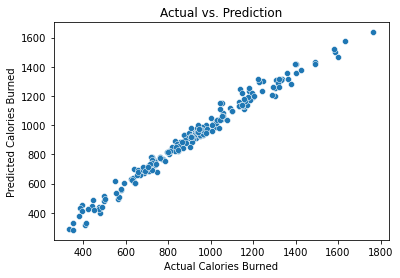

In [11]:
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2:.4f}')

ax = sns.scatterplot(y_test,y_pred)
ax.set(xlabel = "Actual Calories Burned", ylabel = "Predicted Calories Burned")
plt.title("Actual vs. Prediction")

In [8]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE:  {mae:.2f}')
print(f'MSE:  {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE:  30.27
MSE:  1646.18
RMSE: 40.57


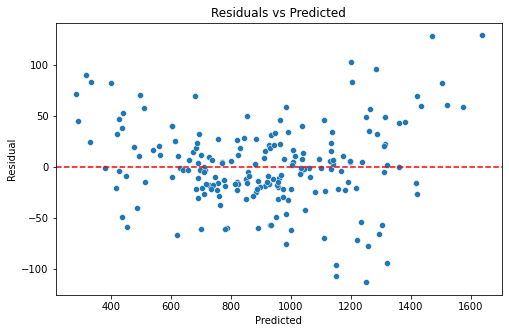

In [9]:


residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted')
plt.show()

# Random Forest

In [50]:
#Define your column types
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(['Calories_Burned']).tolist()

#Build transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # optional, see earlier convo
])

#Combine them into a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

#Full pipeline (preprocessing + model)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())  # or any model you want
])

#Fit your model
model_pipeline.fit(X_train, y_train)

#hyperparameter grid
param_grid = {
    'model__n_estimators': [300, 325],
    'model__max_depth': [None],
    'model__min_samples_split': [2, 1],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}
#grid search
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Evaluation on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n🔍 Best Parameters:")
print(grid_search.best_params_)

print("\n📊 Test Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\noahp\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\noahp\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\noahp\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\noahp\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\noahp\Anaconda3\lib\si


🔍 Best Parameters:
{'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}

📊 Test Set Performance:
R² Score: 0.923
MAE: 62.543
RMSE: 80.094


In [12]:
#Define your column types
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(['Calories_Burned']).tolist()

#Build transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # optional, see earlier convo
])

#Combine them into a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])
#hyperparameter grid
param_grid = {
    'model__n_estimators': [300],
    'model__max_depth': [None],
    'model__min_samples_split': [1],
    'model__min_samples_leaf': [2],
    'model__max_features': ['log2']
}
#Full pipeline (preprocessing + model)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=1.0, min_samples_leaf=2, max_features='log2'))  # or any model you want
])

#Fit your model
model_pipeline.fit(X_train, y_train)



print("\n📊 Test Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")


📊 Test Set Performance:
R² Score: 0.980
MAE: 30.270
RMSE: 40.573


R² Score: 0.9803


c:\Users\noahp\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Actual vs. Prediction')

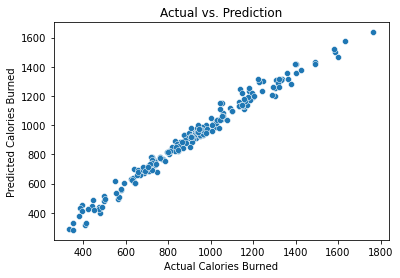

In [13]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2:.4f}')

ax = sns.scatterplot(y_test,y_pred)
ax.set(xlabel = "Actual Calories Burned", ylabel = "Predicted Calories Burned")
plt.title("Actual vs. Prediction")

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE:  {mae:.2f}')
print(f'MSE:  {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE:  62.54
MSE:  6414.98
RMSE: 80.09


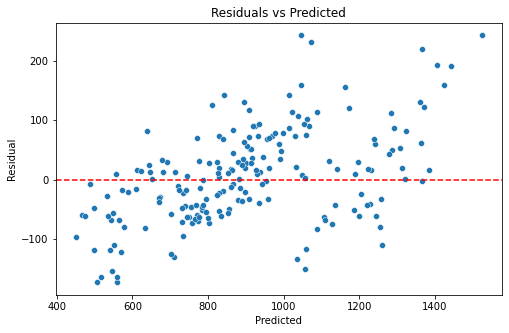

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted')
plt.show()